In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
from ResNN import ClassificationModel2 as ResNN, FocalLoss
import scipy.stats as st
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
from imblearn import over_sampling as osam, under_sampling as usam, combine as cbsam
import sdv
from sdv.sampling import Condition
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False

seed_everything()   

In [6]:
df = pd.read_csv('./impute_set/imp3.csv')

class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.values).float()
        self.y = torch.from_numpy(y.values).long()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def preprocessing(df, numeric='minmax', category='label'):
    X = df.drop('BS3_1', axis=1)
    y = df['BS3_1']
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    if numeric == 'minmax':
        n_pre = MinMaxScaler()
    else:
        n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    if category == 'label':
        c_pre = OrdinalEncoder()
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    else:
        c_pre = OneHotEncoder(sparse_output=False)
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat))

    X = pd.concat([df_num, df_cat], axis=1)
    # uniques = []
    # for col in cat_col:
    #     uniques.append(len(X[col].unique()))
    return X, y


# def test_with_imputations(train_loader, test_loader, test_y, input_dim):
def test_with_imputations(model, train_loader, test_loader, test_y):
    class_counts = torch.tensor([test_y.value_counts()[0], test_y.value_counts()[1]])
    class_weights = 1.0 / class_counts
    class_weights /= class_weights.sum()

    device = torch.device('cuda')
    # model = ResNN(input_dim=input_dim, hidden_dim=512, num_classes=2)
    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    # class_counts = torch.tensor([test_y.value_counts()[0], test_y.value_counts()[1]])
    # class_weights = 1.0 / class_counts
    # class_weights /= class_weights.sum()
    
    criterion = FocalLoss(weight=class_weights.to(device))
    best_f1 = 0.0
    best_epoch = 0
    epochs=500
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xx, yy in train_loader:
            xx, yy = xx.to(device), yy.to(device)
            optim.zero_grad()
            preds = model(xx)
            loss = criterion(preds, yy)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        # print(f'{epoch+1} Epoch | Loss: {running_loss/len(train_loader):.4f}')

        model.eval()
        val_loss = 0
        correct = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for xx, yy in test_loader:
                xx, yy = xx.to(device), yy.to(device)
                preds = model(xx)
                val_loss = criterion(preds, yy).item()
                yy = yy.detach().cpu().numpy().squeeze()
                preds = preds.detach().cpu().numpy().squeeze()
                preds_labels = preds.argmax(axis=1)
                correct += (preds_labels == yy).sum().item()
                val_preds.extend(preds_labels.tolist())
                val_targets.extend(yy.tolist())

        val_loss /= len(test_loader)
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        # print(f'{epoch+1} Epoch | TestLoss: {val_loss:.4f} | TestF1: {val_f1:.4f}')
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch+1
            torch.save(model.state_dict(), 'bestResNN.pth')

    print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')
    return best_f1


def test_with_5fold(df, numeric, category, shuffle=True):
    f1s = []
    X, y = preprocessing(df, numeric, category)
    if shuffle:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle, random_state=42)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
        test_X, test_y = X.iloc[test_idx], y.iloc[test_idx]

        train_set = CustomDataset(train_X, train_y)
        test_set = CustomDataset(test_X, test_y)
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=True, pin_memory=True)

        model = ResNN(input_dim=train_X.shape[-1], hidden_dim=696, num_classes=2)

        f1_value = test_with_imputations(
            # train_loader, test_loader, test_y, input_dim=train_X.shape[-1]
            model, train_loader, test_loader, test_y
        )
        f1s.append(f1_value)

    return f1s


def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95    


def bootstrap_ci(data, n_boot=1000, ci=95):
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(data), np.std(data), (lower, upper)

In [7]:
f1s = test_with_5fold(df, numeric='standard', category='label')
mean_f1, std_f1, ci95 = get_cv_results(f1s)
# print(f1s)
print(f'CV Results: Mean {mean_f1:.2f} | Std {std_f1:.2f} | CI95% {ci95[0]:.2f}~{ci95[1]:.2f}')

_, _, bci95 = bootstrap_ci(f1s)
print(f'Bootstrap CI95% {bci95[0]:.2f}~{bci95[1]:.2f}')

Best Epoch: 3 | Best F1 : 0.8491
Best Epoch: 3 | Best F1 : 0.7843
Best Epoch: 9 | Best F1 : 0.8491
Best Epoch: 24 | Best F1 : 0.7304
Best Epoch: 20 | Best F1 : 0.8326
CV Results: Mean 0.81 | Std 0.05 | CI95% 0.75~0.87
Bootstrap CI95% 0.76~0.85


In [8]:
def forfinal(df):
    from sklearn.model_selection import train_test_split
    f1s = []
    X, y = preprocessing(df)
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)
    class_counts = torch.tensor([train_y.value_counts()[0], train_y.value_counts()[1]])

    sampler = osam.SMOTE(random_state=42)
    # sampler = cbsam.SMOTETomek(random_state=42)
    train_X, train_y = sampler.fit_resample(train_X, train_y)
    train_set = CustomDataset(train_X, train_y)
    test_set = CustomDataset(test_X, test_y)
    g = torch.Generator()
    g.manual_seed(42)
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, generator=g)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, generator=g)

    class_weights = 1.0 / class_counts
    class_weights /= class_weights.sum()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNN(input_dim=train_X.shape[-1], hidden_dim=696, num_classes=2)
    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    criterion = FocalLoss(weight=class_weights.to(device))
    best_f1 = 0.0
    best_epoch = 0
    epochs = 500
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xx, yy in train_loader:
            xx, yy = xx.to(device), yy.to(device)
            optim.zero_grad()
            preds = model(xx)
            loss = criterion(preds, yy)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        model.eval()
        test_loss = 0.0
        corr = 0
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for xx, yy in test_loader:
                xx, yy = xx.to(device), yy.to(device)
                preds = model(xx)
                test_loss += criterion(preds, yy).item()
                yy = yy.detach().cpu().numpy().squeeze()
                preds = preds.detach().cpu().numpy().squeeze()
                preds_labels = preds.argmax(axis=1)
                corr += (preds_labels==yy).sum().item()
                test_preds.extend(preds_labels.tolist())
                test_targets.extend(yy.tolist())
            test_loss /= len(test_loader)
            test_f1 = f1_score(test_targets, test_preds, average='macro')
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_epoch = epoch+1
            torch.save(model.state_dict(), 'bestResNN.pth')
    print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')
    return model, test_set, test_loader

In [9]:
model, test_set, test_loader = forfinal(df)

Best Epoch: 289 | Best F1 : 0.7667


In [10]:
model.load_state_dict(torch.load('./bestResNN.pth'))

<All keys matched successfully>

In [11]:
def model_func(data):
    data = torch.from_numpy(data).float()
    device = torch.device('cuda')
    data = data.to(device)
    return model(data).detach().cpu().numpy()

In [12]:
import shap
explainer = shap.Explainer(model_func, test_set.X.detach().cpu().numpy())

In [13]:
shap_values = explainer.shap_values(test_set.X.detach().cpu().numpy())

In [14]:
cols = df.drop('BS3_1', axis=1).columns

In [15]:
col_dict={
 # categorical (HE_DM | DE1_dg: 당뇨병 의사진단 여부 --> 당뇨병 유병률(Diabetes prevalence))
 'sex':'Sex', 'occp':'Occupation', 'Edu':'Education level', 'EC1_1':'EEA', '금연지지가족친구여부':'FFSQ', 
 'marri_1':'Marital status', '손자손녀동거여부':'LWG', '건강문해력':'PHS', 'HE_PFThs':'CRH', 'HE_cough1':'CL3M',
 'HE_sput1':'SP3M', '가래양상':'Sputum characteristics', 'BH9_11':'Influenza vaccination', 'DI1_dg':'PDG', 
 'DE1_dg':'Diabetes prevalence', 'DC6_dg':'PDLC', 'BP1':'PSL', 'BP5':'DS2W', 'D_1_1':'Health literacy', 'BS5_1':'PQS-1M', 
 '자기효능감':'Self-efficacy', 'N_DUSUAL':'CUFI', 'BE3_31':'WDW', 'BE5_1':'STDW', 'LQ4_05':'Activity limitation', 
 'BH1_1':'Health check-up', 'BO2_1':'BWCY', 'BO1_1':'BWChY', '질환유병기간':'COPD duration', 'DI1_pt':'Hypertension treatment',
 'DI1_2':'AMU', 'DE1_pt':'Diabetes treatment', 'DE1_3':'DMU', '심한금단증상경험여부':'SWS-E', '전문가의금연권유':'PAQ',
 # numeric
#  'FEV1':'FEV1', 'HE_fev1fvc':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'FEV1':'FEV1', 'FEV1FVC':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'BS6_2_1':'Smoking duration', 'BD1':'Alcohol consumption', 'Total_slp_wk':'AST', 'EQ_5D':'QoL'
}

feature_names=[col_dict[fcol] for fcol in cols]

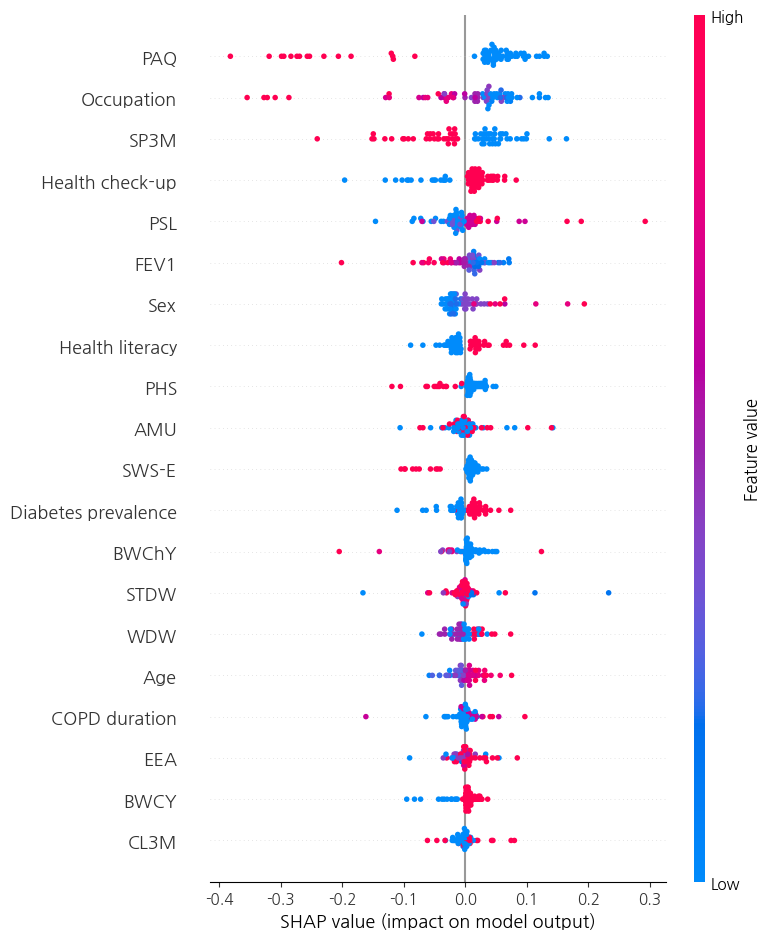

In [17]:
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.suptitle('Shap Values (ResNN)')
shap.summary_plot(shap_values[:,:,0], test_set.X.detach().cpu().numpy(), feature_names=feature_names)
plt.show()